This project demonstrates a practical application of deep learning techniques in anomaly detection, leveraging the inherent capabilities of CNNs and autoencoders to learn and detect deviations in data efficiently.

##  Import Libraries

In [1]:
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Input, Flatten, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import random
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import scipy.stats as stats


# Load and Preprocess Data

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()
batch = 60

train_samples = 10000
test_samples = 1000

x_train_list = list(x_train)
x_train_small = random.sample(x_train_list, train_samples)
x_train_small = np.array(x_train_small)


x_test_list = list(x_test)
x_test_small = random.sample(x_test_list, test_samples)
x_test_small = np.array(x_test_small)

x_train_small = x_train_small.astype('float32')
x_test_small = x_test_small.astype('float32')

x_train_small = x_train_small / 255
x_test_small = x_test_small / 255

img_width  = x_train_small.shape[1]
img_height = x_train_small.shape[2]
num_channels = 1

x_train_small = np.reshape(x_train_small, (len(x_train_small), img_width, img_height, num_channels))
x_test_small = np.reshape(x_test_small, (len(x_test_small), img_width, img_height, num_channels))
img_shape = (img_height, img_width, num_channels)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Anomalous Data (Fashion-MNIST)

In [3]:
(x_anomaly_train, _),(x_anomaly_test, _) = tf.keras.datasets.fashion_mnist.load_data()
anomaly_samples = 2000
_
anomaly_list = list(x_anomaly_train)
anomaly_data = random.sample(anomaly_list, anomaly_samples)
anomaly_data = np.array(anomaly_data)

anomaly_data = anomaly_data.astype('float32')
anomaly_data = anomaly_data / 255
anomaly_data = np.reshape(anomaly_data, (len(anomaly_data), img_width, img_height, num_channels))


anomaly_test_list = list(x_anomaly_test)
anomaly_test_data = random.sample(anomaly_test_list, anomaly_samples)
anomaly_test_data = np.array(anomaly_test_data)

anomaly_test_data = anomaly_test_data.astype('float32')
anomaly_test_data = anomaly_test_data / 255
anomaly_test_data = np.reshape(anomaly_test_data, (len(anomaly_test_data), img_width, img_height, num_channels))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
print(type(x_train))
print(type(x_train_small))
print(type(anomaly_data))
print(len(x_train))
print(x_train.shape)
print(len(x_test))
print(x_test.shape)
print(len(x_train_small))
print(len(x_test_small))
print(len(anomaly_data))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
60000
(60000, 28, 28)
10000
(10000, 28, 28)
10000
1000
2000


# Visualizing Data Samples
Display Random Training Data Samples (MNIST)

[8770, 8951, 7413, 3914, 3932, 1589, 4655, 8941, 7753, 3114]

Few of the training data samples are:


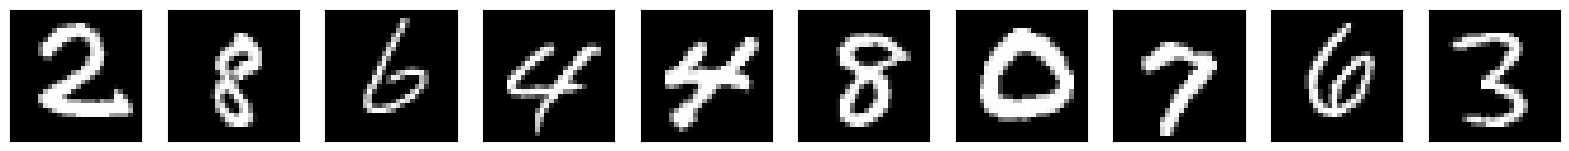

In [5]:
n = []
a = 0
for j in range(0, 10):
    n.append(random.randint(0, train_samples))
print(n)

print('\nFew of the training data samples are:')
plt.figure(figsize=(20, 4))
for i in n:
    a = a + 1
    ax = plt.subplot(2, 10, a)
    plt.imshow(x_train_small[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Display Anomaly Data Samples (Fashion-MNIST)

[1991, 773, 1398, 1166, 795, 538, 715, 289, 701, 369]

Few of the Anomaly data samples are:


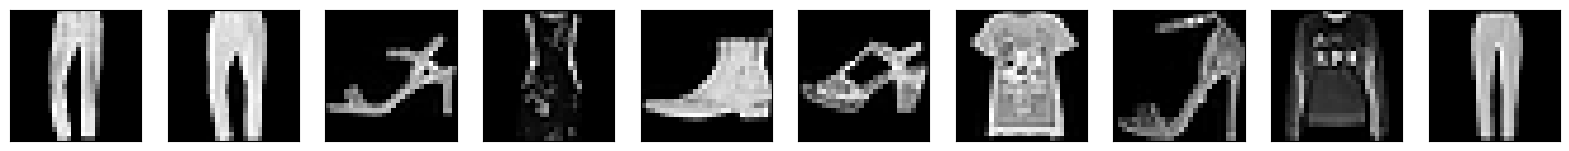

In [6]:
f = []
b = 0
for j in range(0, 10):
    f.append(random.randint(0, len(anomaly_data)-1))
print(f)

print('\nFew of the Anomaly data samples are:')
plt.figure(figsize=(20, 4))

for i in f:
    b = b + 1
    ax = plt.subplot(2, 10, b)
    plt.imshow(anomaly_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Building the Autoencoder Model

In [7]:
input_img = keras.Input(shape = img_shape)

x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
decoded = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy'])

In [8]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

# Training the Autoencoder

In [9]:
a = autoencoder.fit(x_train_small, x_train_small,
                epochs= 25,
                batch_size=batch,
                shuffle=True,
                validation_data=(x_test_small, x_test_small))

Epoch 1/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.7589 - loss: 0.4648 - val_accuracy: 0.7852 - val_loss: 0.2048
Epoch 2/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.7909 - loss: 0.1934 - val_accuracy: 0.7966 - val_loss: 0.1690
Epoch 3/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.7967 - loss: 0.1657 - val_accuracy: 0.8030 - val_loss: 0.1537
Epoch 4/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.8013 - loss: 0.1498 - val_accuracy: 0.8047 - val_loss: 0.1402
Epoch 5/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.8048 - loss: 0.1396 - val_accuracy: 0.8053 - val_loss: 0.1327
Epoch 6/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.8056 - loss: 0.1330 - val_accuracy: 0.8056 - val_loss: 0.1280
Epoch 7/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8072 - loss: 0.1288 - val_accuracy: 0.8077 - val_loss: 0.1251
Epoch 8/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.8079 - loss: 0.1253 - 

# Evaluating the Autoencoder

In [10]:
decoded_imgs = autoencoder.predict(x_test_small)
decoded_imgs_anom = autoencoder.predict(anomaly_data)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


# Plot Training Loss

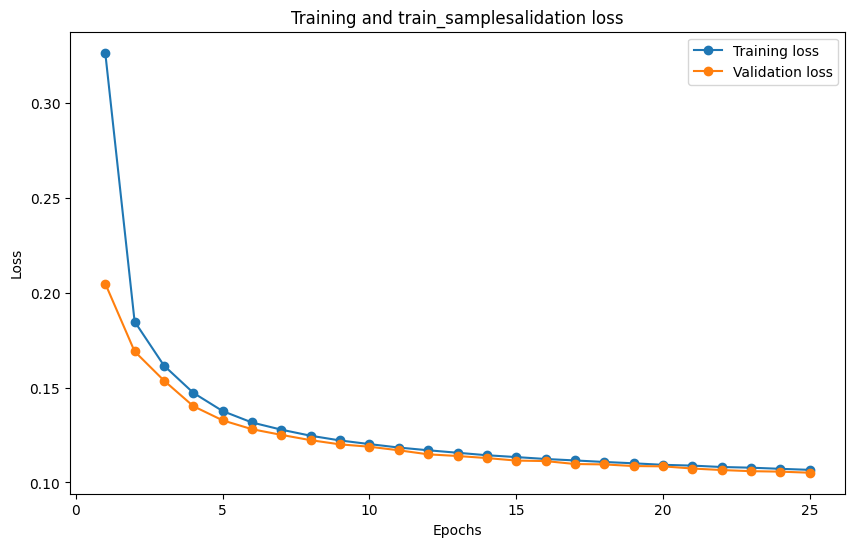

In [11]:
plt.rcParams["figure.figsize"] = (10,6)
loss = a.history['loss']
val_loss = a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, '-o', label='Training loss')
plt.plot(epochs, val_loss, '-o', label='Validation loss')
plt.title('Training and train_samplesalidation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Compare Original and Reconstructed Images

The orignal images are:


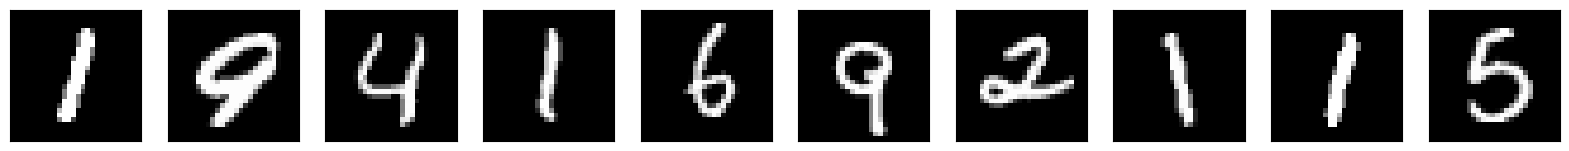


The reconstructed images are:


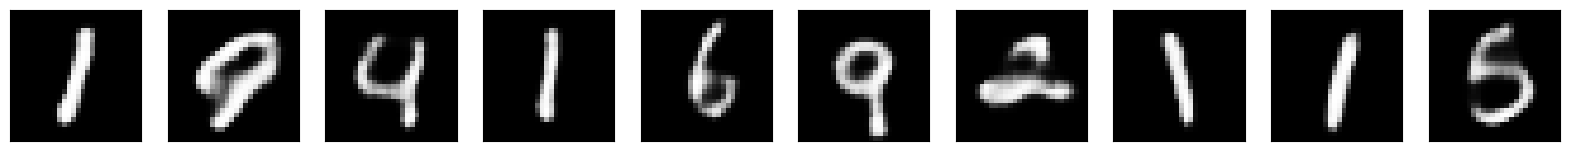

In [12]:
n = 10
plt.figure(figsize=(20, 4))
print("The orignal images are:")
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_small[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("\nThe reconstructed images are:")
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Calculate Reconstruction Error

In [13]:
recon_error_list=[]

for i in range(1, 100):
    reconstruction_error = autoencoder.evaluate([decoded_imgs[i:i+1]],[x_test_small[i:i+1]])
    recon_error_list.append(reconstruction_error)
recon_error_list = np.array(recon_error_list)

ano_recon_error_list=[]

for i in range(1, 100):
    ano_recon_error = autoencoder.evaluate([decoded_imgs_anom[i:i+1]],[anomaly_data[i:i+1]])
    ano_recon_error_list.append(ano_recon_error)
ano_recon_error_list = np.array(ano_recon_error_list)

def Extract(lst):
    return [item[0] for item in lst]

recon_error_list = Extract(recon_error_list)
ano_recon_error_list = Extract(ano_recon_error_list)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 28, 28, 1))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9617 - loss: 0.0360
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7143 - loss: 0.1339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8406 - loss: 0.1232
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9043 - loss: 0.0483
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8597 - loss: 0.1271
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8253 - loss: 0.0986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7921 - loss: 0.2211
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8992 - loss: 0.0586
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9656 - loss: 0.0384
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8048 - loss: 0.1428
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8406 - loss: 0.0595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7321 - loss: 0.1826
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8508 - loss: 0.0942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8929 - loss

# Visualizing Reconstruction Errors

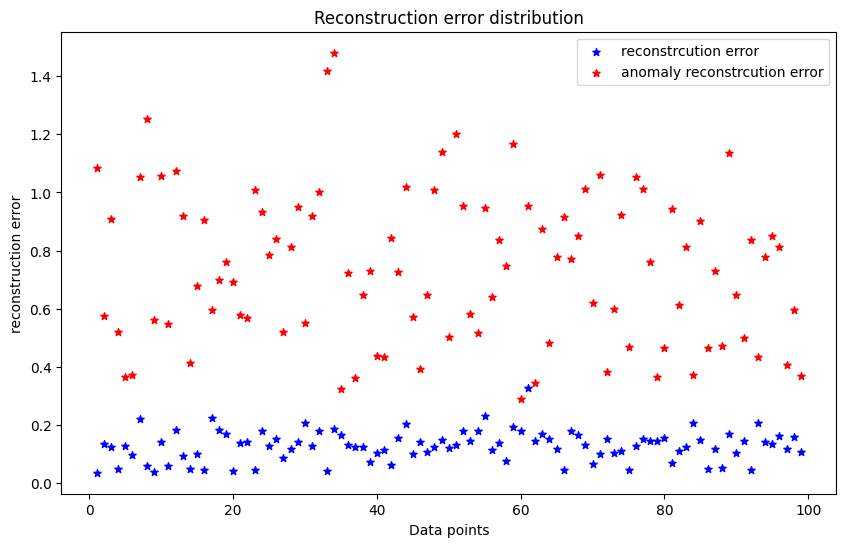

In [14]:
x = list(range(1,len(recon_error_list)+1,1))
y = list(range(1,len(ano_recon_error_list)+1,1))

plt.scatter(x, recon_error_list, label= "reconstrcution error", color= "blue", marker= "*", s=30)
plt.scatter(y, ano_recon_error_list, label= "anomaly reconstrcution error", color= "red", marker= "*", s=30)
plt.xlabel('Data points')
plt.ylabel('reconstruction error')
plt.title('Reconstruction error distribution')
plt.legend()
plt.show()

# Anomaly Detection Threshold

The distribution of the reconstruction error is:

The mean of the reconstruction error is 0.1288 
The standard deviation of the reconstruction error is 0.0519


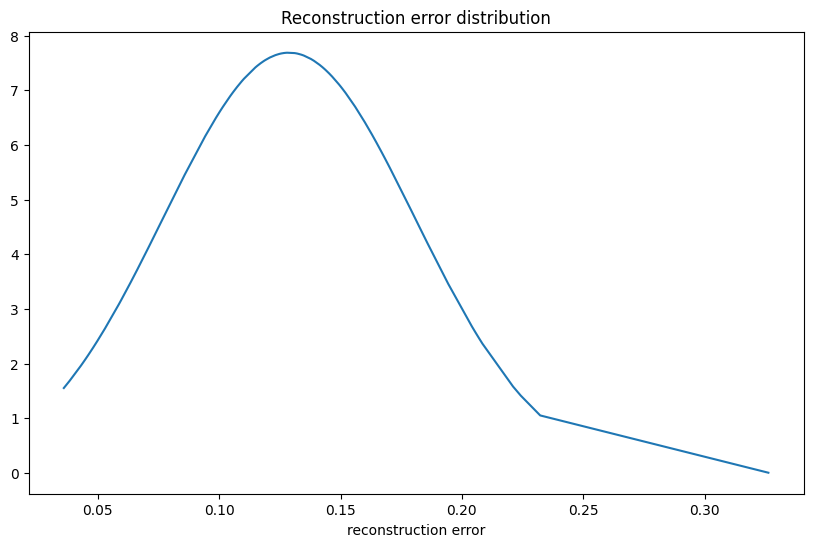

In [15]:
print("The distribution of the reconstruction error is:")

re = recon_error_list
re.sort()
re_mean = np.mean(re)
re_std = np.std(re)

print("\nThe mean of the reconstruction error is",format(re_mean,".4f"),
      "\nThe standard deviation of the reconstruction error is",format(re_std,".4f"))

pdf = stats.norm.pdf(re, re_mean, re_std)
plt.plot(re, pdf)
plt.xlabel('reconstruction error')
plt.title('Reconstruction error distribution')
plt.show()

The threshold values are as follows: 0.2326 , 0.0250

The thresholds can be visualised below:


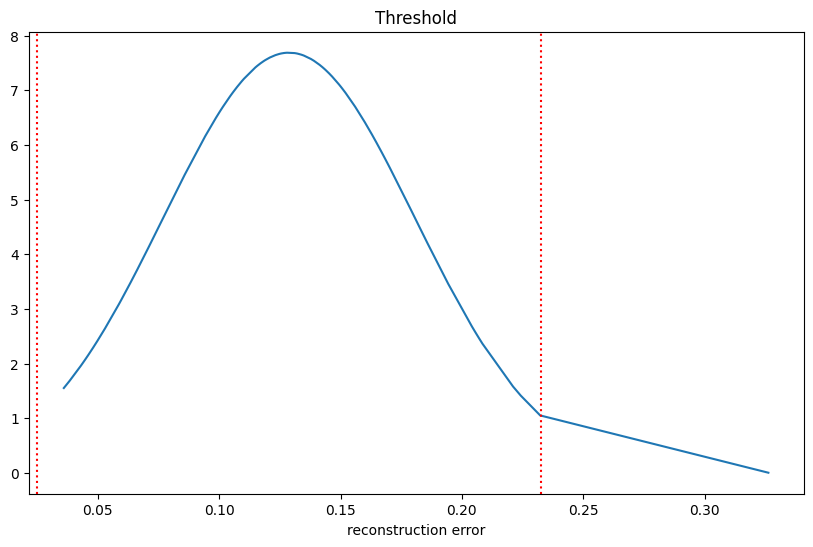

In [16]:
threshold = [re_mean + (2*re_std) ,re_mean - (2*re_std)]
print("The threshold values are as follows:",format(threshold[0],".4f"),",",format(threshold[1],".4f"))

print("\nThe thresholds can be visualised below:")

re = recon_error_list
re.sort()
re_mean = np.mean(re)
re_std = np.std(re)
pdf = stats.norm.pdf(re, re_mean, re_std)
plt.plot(re, pdf)
plt.axvline(x = threshold[0], color = 'red', linestyle='dotted')
plt.axvline(x = threshold[1], color = 'red', linestyle='dotted')
plt.xlabel('reconstruction error')
plt.title('Threshold')
plt.show()

In [17]:
test  = autoencoder.predict(anomaly_test_data)
anomaly_det= 0
test_data_nos = 500

for i in range(1, test_data_nos):
    test_reconstruction_error = autoencoder.evaluate(test[i:i+1],anomaly_data[i:i+1])
    if test_reconstruction_error[0] > threshold[0] or test_reconstruction_error[0] < threshold[1]:
        anomaly_det += 1

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2832 - loss: 2.4300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3673 - loss: 1.1471
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3431 - loss: 1.8693
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4923 - loss: 3.0977
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4936 - loss: 1.2546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4605 - loss: 1.1833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3622 - loss: 1.3285
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2793 - loss: 2.0087
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4515 - loss: 1.5971
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3202 - loss: 2.9470
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4694 - loss: 0.7818
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2793 - loss: 2.9096
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3737 - loss: 1.2840
1/1 ━━━━━━━━━━━━━━━━━━━━

In [18]:
accuracy = anomaly_det/test_data_nos *100
print("Accuracy of the model detecting an anomaly is: ",accuracy)

Accuracy of the model detecting an anomaly is:  99.8


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


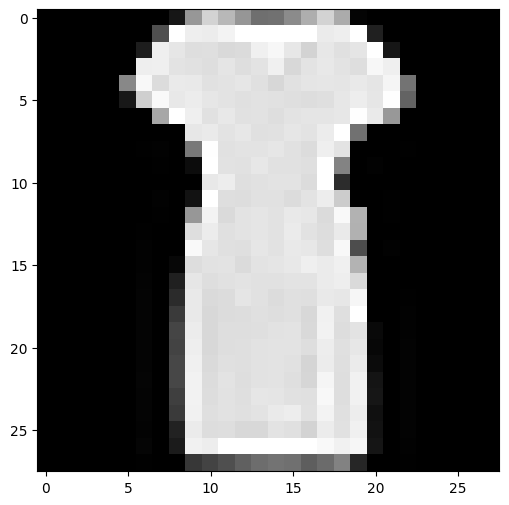

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6480 - loss: 0.6472

The reconstruction error is:  0.6472
Anomaly Detected


In [19]:
test  = autoencoder.predict(anomaly_data)

plt.imshow(anomaly_data[0].reshape(28, 28))
plt.show()

test_reconstruction_error = autoencoder.evaluate(test[i:i+1],anomaly_data[i:i+1])
print('\nThe reconstruction error is: ',format(test_reconstruction_error[0],'.4f'))

if test_reconstruction_error[0] > threshold[0] or test_reconstruction_error[0] < threshold[1]:
    print("Anomaly Detected")
else:
    print("Data is Pure")